In [1]:
from nbodykit.lab import *
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

import sys
sys.path.append('../general_routines/')
from general_tools import *
from iterative_reconstruction import *

In [2]:
cosmo = cosmology.Planck15

### Import matter catalog
matter = BigFileCatalog('Matter_catalog.bigfile')

# Define global variables
Length = matter.attrs['BoxSize'][0]
Nc = matter.attrs['Nmesh'][0]
zobs = 0.3
zinit = 3.
r_s = 2.*(Length/Nc) # smoothing radius
print('Smoothing radius=', r_s)

### Import galaxy catalog
galaxy = BigFileCatalog('Galaxy_catalog.bigfile')

bg, bg_std = evaluate_bias(galaxy, matter, return_std=True)
bgRSD, bgRSD_std = evaluate_bias(galaxy, matter, tracer_pos='PositionRSD', return_std=True)

print('Bias before reconstruction at z={:.2f}'.format(zobs))
print('bias (real)= {:.3f} +- {:.3f}'.format(bg, bg_std))
print('bias (redshift)= {:.3f} +- {:.3f}'.format(bgRSD, bgRSD_std))

/home/pdcg/miniconda3/envs/nbodykit-env/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


Smoothing radius= 7.8125
Bias before reconstruction at z=0.30
bias (real)= 1.418 +- 0.018
bias (redshift)= 1.645 +- 0.018


In [7]:
# Valores de formulas (redshift)
print('Expected bias after reconstruction at z={:.2f}'.format(zinit))
breczinitt = (bgRSD-1)*(D(zobs)/D(zinit)) + 1
breczobst = (bgRSD-1) + (D(zinit)/D(zobs))

print('Bias brec(zinit) = {:.3f}'.format(breczinitt))
print('Bias brec(zobs) = {:.3f}'.format(breczobst))

Expected bias after reconstruction at z=3.00
Bias brec(zinit) = 2.740
Bias brec(zobs) = 1.016


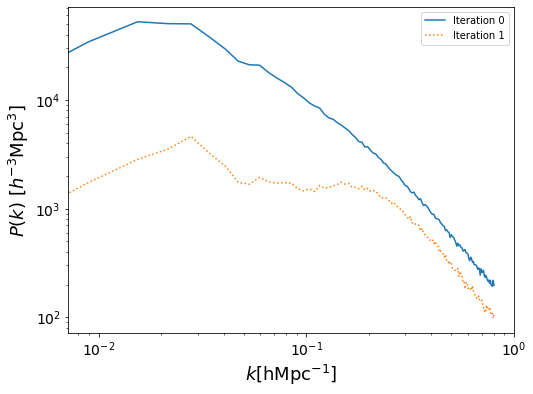

Iteration 1, Mean difference between Pks: 3743.82


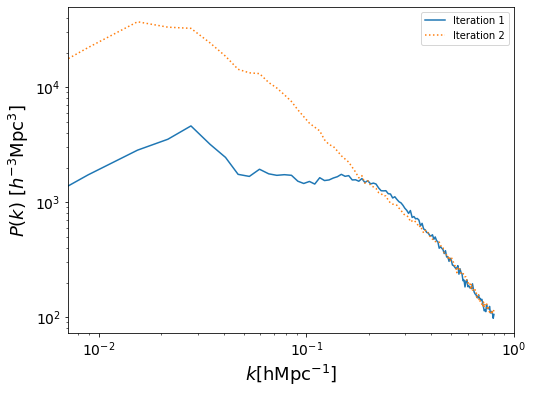

Iteration 2, Mean difference between Pks: 1918.03


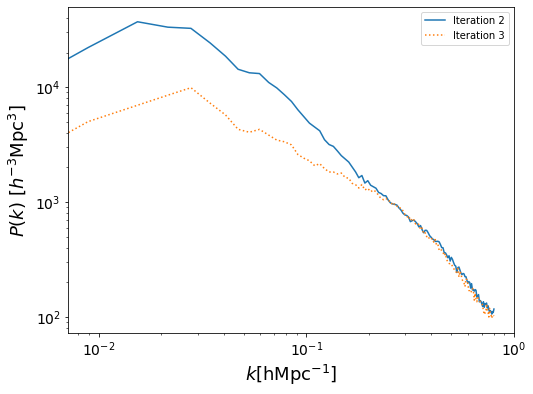

Iteration 3, Mean difference between Pks: 1573.60


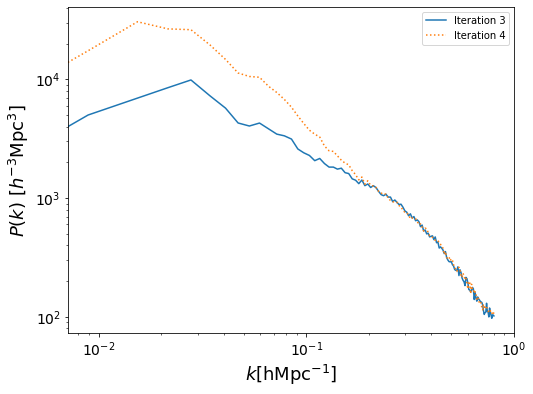

Iteration 4, Mean difference between Pks: 1098.48


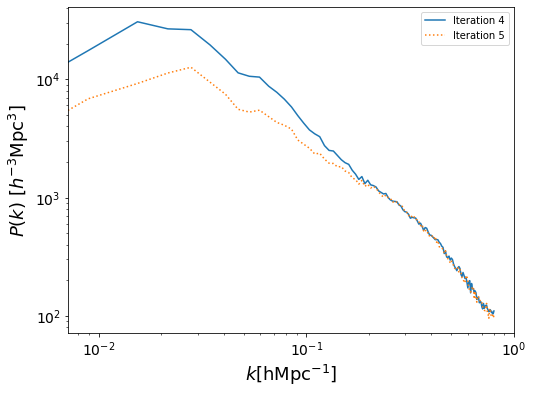

Iteration 5, Mean difference between Pks: 921.96


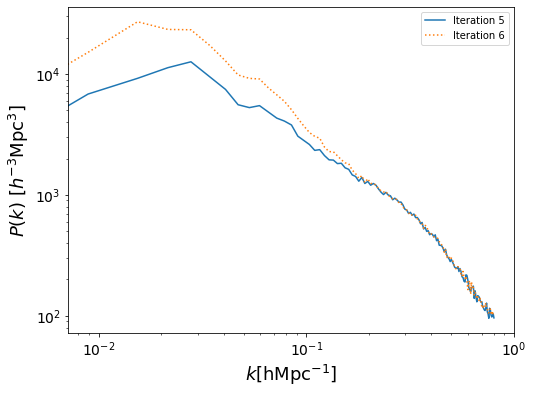

Iteration 6, Mean difference between Pks: 699.27


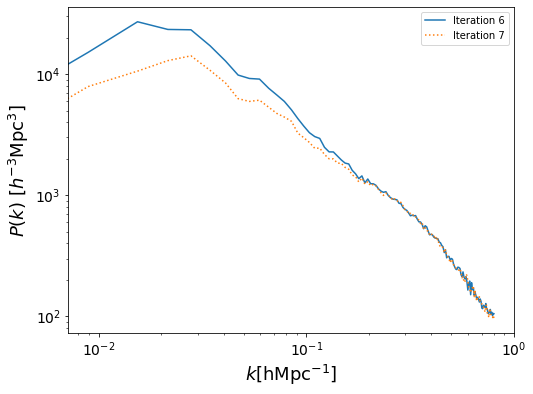

Iteration 7, Mean difference between Pks: 602.83


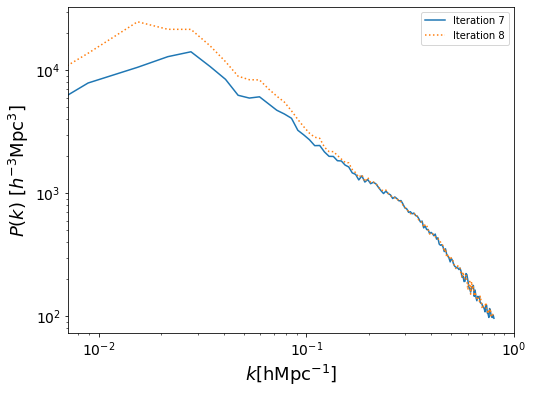

Iteration 8, Mean difference between Pks: 480.31


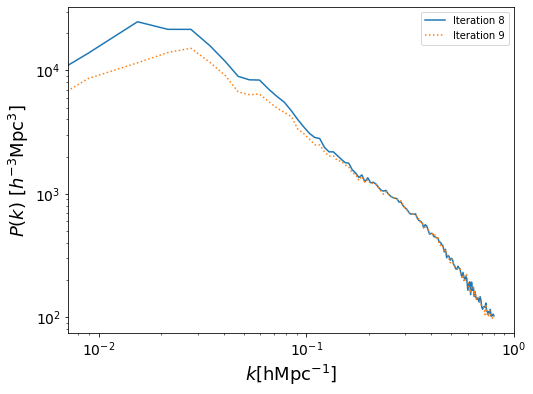

Iteration 9, Mean difference between Pks: 421.57


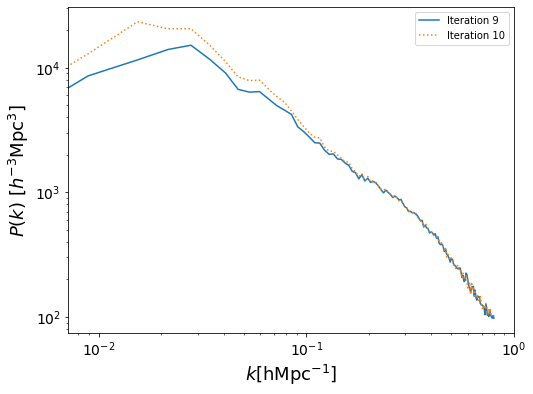

Iteration 10, Mean difference between Pks: 348.84


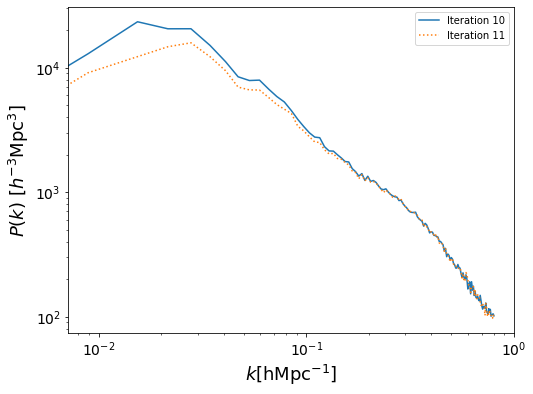

Iteration 11, Mean difference between Pks: 310.79


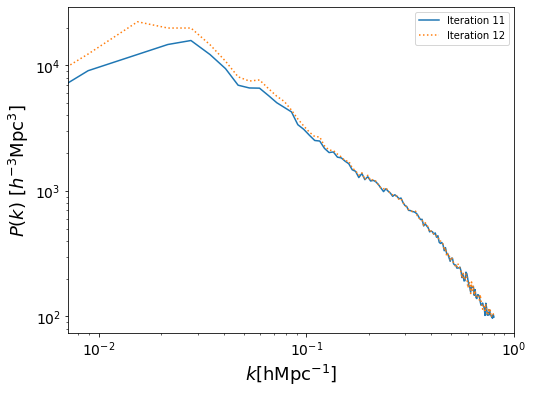

Iteration 12, Mean difference between Pks: 266.46


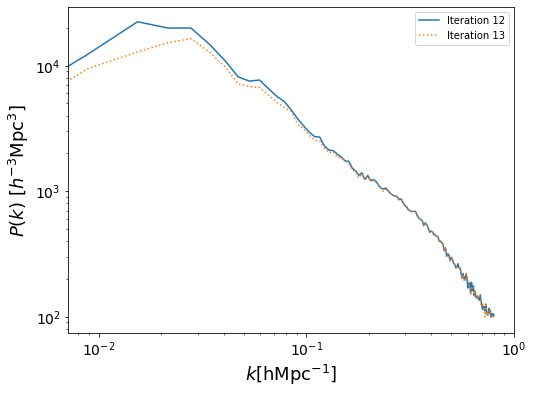

Iteration 13, Mean difference between Pks: 239.98


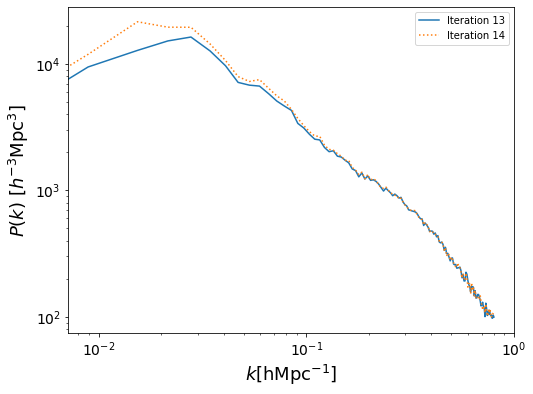

Iteration 14, Mean difference between Pks: 213.74


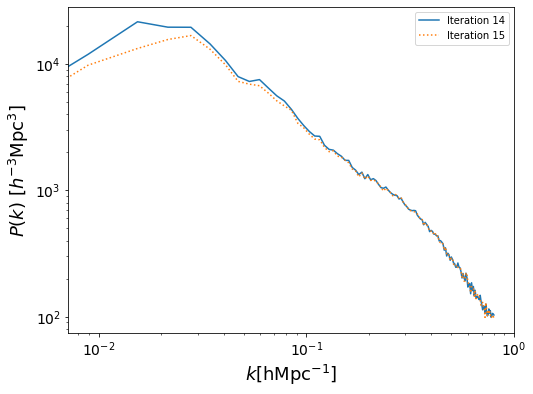

Iteration 15, Mean difference between Pks: 194.15


##########################
Reconstruction Finalized
##########################


bias (redshift) POST= 2.681(z=3.00),0.994(z=0.30)


In [5]:
# Reconstruction from redshift position
iterative_reconstruction(15, Length, Nc, zobs, zinit, galaxy, matter, np.array([Length/2, Length/2, Length/2]), plot_iterations=True)

# Reconstructed bias
bgrecons2 = evaluate_bias(galaxy, matter, tracer_pos='PositionQS')
bgrecons1 = bgrecons2 * D(zobs)/D(zinit)

print('\n')
print('##########################')
print('Reconstruction Finalized')
print('##########################')
print('\n')
print('bias (redshift) POST= {:.3f}(z={:.2f}),{:.3f}(z={:.2f})'.format(bgrecons1, zinit,bgrecons2, zobs))

In [5]:
# Test of the iterative reconstruction from the actual DM field
iterative_reconstruction(0, Length, Nc, zobs, zinit, galaxy, matter, np.array([Length/2, Length/2, Length/2]), plot_iterations=True, test=True)

# Reconstructed bias
bgrecons2 = evaluate_bias(galaxy, matter, tracer_pos='PositionQS')
bgrecons1 = bgrecons2 * D(zobs)/D(zinit)

print('##########################')
print('Reconstruction Finalized')
print('##########################')
print('bias (test) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgrecons1, zinit,bgrecons2, zobs))

##########################
Reconstruction Finalized
##########################
bias (test) POST= 1.90(z=3.00),0.71(z=0.30)
